<a href="https://colab.research.google.com/github/jakericedesigns/Pytorch-Experiments/blob/main/Voronoi_Noise_Neural_Implicit_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Origins
A collection of experiments that stemmed from the recent article ["Spherical Voronoi"](https://arxiv.org/abs/2512.14180) by Di Sario et al.

I wanted to explore incorporating anisotropy as a parameter into the optimization process. Lucky Iyinbor initially tried out the idea, to great success which inspired me to try it as well. It's a bit slow to optimize

## Follow Ups

Following the initial success of the anisotropy, and having recently explored anisotropic perlin and simplex noise, I decided to try implementing a similar idea for simplex noise based optimization.

And then following the success of that, I thought back to other noises and remembered that the formulation for gabor noise (and phasor noise), is similar to the voronoi formulation we used in the anisotropic voronoi experiment. It turns out that the inclusion of a gabor style weight into the voronoi is similarly effective to the anisotropic method.

## What's Included

I've included 4 toy models based on the experiments.


*   Isotropic Voronoi - 'voronoi'
*   Anisotropic Voronoi - 'aniso_voronoi'
*   Gabor Voronoi - 'gaboronoi'
*   Simplex Noise - 'simplex'

These can be swapped out in the train_env_model() function below.


In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Tuple
from skimage import data
from scipy.ndimage import zoom, gaussian_filter
from tqdm import tqdm

img = data.cat()


WIDTH = 1024
HEIGHT = 1024
BLUR = 0


In [2]:
def get_device(device=None):
    if device is None:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device(device)

In [3]:
def softplus_inv(x: float) -> float:
    return math.log(math.exp(x) - 1.0)


def random_sites(num_sites, device=None):
    device = get_device(device)
    sites = torch.rand((num_sites,2), device=device)
    return sites#torch.tensor(sites, device=device)

In [4]:
class GaboronoiModel(nn.Module):
    def __init__(self, num_sites, init_beta=5000.0, device=None,
                 lr_sites=2e-4, lr_colors=1e-3, lr_beta=5, lr_theta = 1e-3, lr_f=1,
                 beta_min=100, beta_max=100000.0):
        super().__init__()
        self.num_sites = num_sites
        self.device = get_device(device)
        self.beta_min = beta_min
        self.beta_max = beta_max

        vectors = random_sites(num_sites, device=self.device).reshape(num_sites, 1, 2)
        self._sites = nn.Parameter(vectors)

        init_beta_clamped = float(max(beta_min, min(beta_max, init_beta)))
        beta_raw_init =init_beta_clamped# softplus_inv(init_beta_clamped)
        self._beta_raw = nn.Parameter(torch.ones((num_sites, 1,  1), device=self.device) * beta_raw_init)
        self._theta = nn.Parameter(torch.rand((num_sites, 1), device=self.device) * 2 * 3.14159265)
        self._f = nn.Parameter(torch.rand((num_sites, 1), device=self.device) * 1000)
        self._colors = nn.Parameter(torch.ones((num_sites, 1, 3), device=self.device) * 0.5)

        cmap = plt.get_cmap("tab20")
        self.palette = torch.tensor([cmap(i % cmap.N)[:3] for i in range(num_sites)],
                               dtype=torch.float32, device=device)


        params = [
            {"params": [self._sites], "lr": lr_sites,  "name": "sites"},
            {"params": [self._colors], "lr": lr_colors, "name": "colors"},
            {"params": [self._beta_raw], "lr": lr_beta, "name": "beta"},
            {"params": [self._theta], "lr": lr_theta, "name": "theta"},
            {"params": [self._f], "lr": lr_f, "name": "f"},

        ]
        self.optimizer = torch.optim.Adam(params, lr=0.0, eps=1e-15)

    def beta(self):
        b = F.softplus(self._beta_raw)
        return torch.clamp(b, self.beta_min, self.beta_max)

    def generate_u(self, eps=1e-8):
        c = torch.cos(self._theta)
        s = torch.sin(self._theta)
        G = torch.stack([c, s], dim=-1)
        return G



    #since we aren't using spherical voronoi, viewing angle is just sample positions
    #and we need to do our voronoi distances here
    def forward(self, sample_p: torch.Tensor) -> torch.Tensor:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site


        beta = self.beta()
        u = self.generate_u()
        scores = (dir_to_sites * dir_to_sites).sum(dim=-1)

        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        scores = scores

        W = torch.softmax(scores, dim=1)  * (torch.sin(self._f * (dir_to_sites * u.unsqueeze(0)).sum(dim=-1)) + 1) * .5 #does exponential weighting and makes it gaboronoi
        V = (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return V


    #extracts both the voronoi and the color map visualizations
    def viz_ALL(self,  sample_p: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site


        beta = self.beta()
        u = self.generate_u()
        scores = (dir_to_sites * dir_to_sites).sum(dim=-1)

        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        scores = scores

        W = torch.softmax(scores, dim=1)  * (torch.sin(self._f * (dir_to_sites * u.unsqueeze(0)).sum(dim=-1)) + 1) * .5 #does exponential weighting and makes it gaboronoi

        VORO = (W * torch.relu(self.palette).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures voronoi colors are above 0 and weights them by site
        COL =  (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return COL, VORO


In [5]:
class AnisotropicVoronoiModel(nn.Module):
    def __init__(self, num_sites, init_beta=5000.0, device=None,
                 lr_sites=2e-4, lr_colors=1e-3, lr_beta=5, lr_theta = 1e-3, lr_r1=1e-3, lr_r2=1e-3,
                 beta_min=100, beta_max=100000.0):
        super().__init__()
        self.num_sites = num_sites
        self.device = get_device(device)
        self.beta_min = beta_min
        self.beta_max = beta_max

        vectors = random_sites(num_sites, device=self.device).reshape(num_sites, 1, 2)
        self._sites = nn.Parameter(vectors)

        init_beta_clamped = float(max(beta_min, min(beta_max, init_beta)))
        beta_raw_init =init_beta_clamped# softplus_inv(init_beta_clamped)
        self._beta_raw = nn.Parameter(torch.ones((num_sites, 1,  1), device=self.device) * beta_raw_init)
        self._theta = nn.Parameter(torch.ones((num_sites, 1), device=self.device))
        self._r1 = nn.Parameter(torch.ones((num_sites, 1), device=self.device))
        self._r2 = nn.Parameter(torch.ones((num_sites, 1), device=self.device))
        self._colors = nn.Parameter(torch.ones((num_sites, 1, 3), device=self.device) * 0.5)

        cmap = plt.get_cmap("tab20")
        self.palette = torch.tensor([cmap(i % cmap.N)[:3] for i in range(num_sites)],
                               dtype=torch.float32, device=device)


        params = [
            {"params": [self._sites], "lr": lr_sites,  "name": "sites"},
            {"params": [self._colors], "lr": lr_colors, "name": "colors"},
            {"params": [self._beta_raw], "lr": lr_beta, "name": "beta"},
            {"params": [self._theta], "lr": lr_theta, "name": "theta"},
            {"params": [self._r1], "lr": lr_r1, "name": "r1"},
            {"params": [self._r2], "lr": lr_r2, "name": "r2"},
        ]
        self.optimizer = torch.optim.Adam(params, lr=0.0, eps=1e-15)

    def beta(self):
        b = F.softplus(self._beta_raw)
        return torch.clamp(b, self.beta_min, self.beta_max)

    def generate_metric(self, eps=1e-8):
        c = torch.cos(self._theta)
        s = torch.sin(self._theta)

        r1 = torch.clamp(self._r1, min=eps)
        r2 = torch.clamp(self._r2, min=eps)

        inv_r1_2 = 1.0 / (r1 * r1)
        inv_r2_2 = 1.0 / (r2 *  r2)
        g11 = c*c * inv_r1_2 + s*s * inv_r2_2
        g22 = s*s * inv_r1_2 + c*c * inv_r2_2
        g12 = c*s * (inv_r1_2 - inv_r2_2)
        G = torch.stack([torch.stack([g11, g12], dim=-1), torch.stack([g12, g22], dim=-1)], dim=-2)
        return G


    #since we aren't using spherical voronoi, viewing angle is just sample positions
    #and we need to do our voronoi distances here
    def forward_no_aniso(self, sample_p: torch.Tensor) -> torch.Tensor:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site
        beta = self.beta()
        scores = (dir_to_sites * dir_to_sites).sum(dim=-1)
        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        W = torch.softmax(scores, dim=1) #does exponential weighting
        V = (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return V

    #since we aren't using spherical voronoi, viewing angle is just sample positions
    #and we need to do our voronoi distances here
    def forward(self, sample_p: torch.Tensor) -> torch.Tensor:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site


        beta = self.beta()
        metrics = self.generate_metric()
        scores = (dir_to_sites * torch.matmul(dir_to_sites, metrics.squeeze(1).unsqueeze(0) )).sum(dim=-1)
        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        W = torch.softmax(scores, dim=1) #does exponential weighting
        V = (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return V


    #extracts both the voronoi and the color map visualizations
    def viz_ALL(self,  sample_p: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site

        beta = self.beta()
        metrics = self.generate_metric()
        scores = (dir_to_sites * torch.matmul(dir_to_sites, metrics.squeeze(1).unsqueeze(0) )).sum(dim=-1)
        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        W = torch.softmax(scores, dim=1) #does exponential weighting
        VORO = (W * torch.relu(self.palette).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures voronoi colors are above 0 and weights them by site
        COL =  (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return COL, VORO



In [6]:
class VoronoiModel(nn.Module):
    def __init__(self, num_sites, init_beta=5000.0, device=None,
                 lr_sites=2e-4, lr_colors=1e-3, lr_beta=5,
                 beta_min=100, beta_max=100000.0):
        super().__init__()
        self.num_sites = num_sites
        self.device = get_device(device)
        self.beta_min = beta_min
        self.beta_max = beta_max

        vectors = random_sites(num_sites, device=self.device).reshape(num_sites, 1, 2)
        self._sites = nn.Parameter(vectors)

        init_beta_clamped = float(max(beta_min, min(beta_max, init_beta)))
        beta_raw_init =init_beta_clamped# softplus_inv(init_beta_clamped)
        self._beta_raw = nn.Parameter(torch.ones((num_sites, 1,  1), device=self.device) * beta_raw_init)
        self._colors = nn.Parameter(torch.ones((num_sites, 1, 3), device=self.device) * 0.5)

        cmap = plt.get_cmap("tab20")
        self.palette = torch.tensor([cmap(i % cmap.N)[:3] for i in range(num_sites)],
                               dtype=torch.float32, device=device)


        params = [
            {"params": [self._sites], "lr": lr_sites,  "name": "sites"},
            {"params": [self._colors], "lr": lr_colors, "name": "colors"},
            {"params": [self._beta_raw], "lr": lr_beta, "name": "beta"},
        ]
        self.optimizer = torch.optim.Adam(params, lr=0.0, eps=1e-15)

    def beta(self):
        b = F.softplus(self._beta_raw)
        return torch.clamp(b, self.beta_min, self.beta_max)


    #since we aren't using spherical voronoi, viewing angle is just sample positions
    #and we need to do our voronoi distances here
    def forward(self, sample_p: torch.Tensor) -> torch.Tensor:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site
        beta = self.beta()
        scores = (dir_to_sites * dir_to_sites).sum(dim=-1)
        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        W = torch.softmax(scores, dim=1) #does exponential weighting
        V = (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return V


    #extracts both the voronoi and the color map visualizations
    def viz_ALL(self,  sample_p: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        sites_p = self._sites
        dir_to_sites = sites_p - sample_p.unsqueeze(1).unsqueeze(1) #direction to site
        beta = self.beta()
        scores = (dir_to_sites* dir_to_sites).sum(dim=-1)
        scores = scores * -beta.squeeze(-1).unsqueeze(0) #dot(sites_dir, viewing angle) * temp
        W = torch.softmax(scores, dim=1) #does exponential weighting
        VORO = (W * torch.relu(self.palette).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures voronoi colors are above 0 and weights them by site
        COL =  (W * torch.relu(self._colors).squeeze(1).unsqueeze(0)).sum(dim=1) #ensures colors are above 0 and weights them by site
        return COL, VORO



In [7]:
simplex_F = 0.366025403784
simplex_G = 0.211324865405


def rand_dir(index):
    h = torch.sin(index[..., 0] * 12.9898 + index[..., 1] * 78.233) * 43758.5453
    angle = 2 * math.pi * torch.frac(h)
    return torch.stack((torch.cos(angle), torch.sin(angle)), dim=-1)


#good settings are 64 noise layers by 48 aniso layers
class SimplexNoiseModel(nn.Module):
    def __init__(self, num_noise_layers=24, aniso_texture_res=48, device=None, width=WIDTH, height=HEIGHT,
                 lr_scale = 1e-4, lr_offset = .1, lr_colors=1e-3,  lr_aniso = 1e-3, mask_p_lr = 1e-3, mask_r_lr=1e-2):
        super().__init__()
        self.device = get_device(device)

        self.aniso_width_height = aniso_texture_res
        self.num_noise_layers = num_noise_layers
        x_range = torch.arange(start=1.0, end=float(self.num_noise_layers) + 1.0,  device=self.device).unsqueeze(-1)

        self._scale = nn.Parameter(x_range * (1.0/num_noise_layers) * 20)

        self._offset = nn.Parameter(torch.rand((num_noise_layers, 2), device=self.device))
        self._aniso = nn.Parameter(torch.ones((num_noise_layers, self.aniso_width_height, self.aniso_width_height, 3), device=self.device)) #theta, r1, r2 as a single texture
        self._color_a = nn.Parameter(torch.rand((num_noise_layers, 3), device=self.device))
        self._color_b = nn.Parameter(torch.rand((num_noise_layers, 3), device=self.device))
        self._mask_p = nn.Parameter(torch.rand((num_noise_layers, 2), device=self.device))
        self._mask_r = nn.Parameter(torch.rand((num_noise_layers, 1), device=self.device))

        params = [
            {"params": [self._color_a], "lr": lr_colors, "name": "color_a"},
            {"params": [self._color_b], "lr": lr_colors, "name": "color_b"},
            {"params": [self._scale], "lr": lr_scale, "name": "scales"},
            {"params": [self._offset], "lr": lr_offset, "name": "offsets"},
            {"params": [self._aniso], "lr": lr_aniso, "name": "aniso parms"},
            {"params": [self._mask_p], "lr": mask_p_lr, "name": "aniso parms"},
            {"params": [self._mask_r], "lr": mask_r_lr, "name": "aniso parms"},
        ]
        self.optimizer = torch.optim.Adam(params, lr=0.0, eps=1e-15)


    #i didn't want to write a bicubic sampler so chatgpt did this for me, which is  cringe but it works
    def bicubic_sample(self, field, pos, w, h):
        """
        field : [L, W, H, V]
        pos   : [S, 2]
        return: [L, S, V]
        """

        device = field.device
        L, W, H, V = field.shape
        S = pos.shape[0]

        x = pos[:, 0] * w
        y = pos[:, 1] * h

        x0 = torch.floor(x).long()
        y0 = torch.floor(y).long()

        dx = x - x0.float()
        dy = y - y0.float()

        def cubic(t, a=-0.5):
            at = torch.abs(t)
            at2 = at ** 2
            at3 = at ** 3
            return torch.where(
                at <= 1,
                (a + 2) * at3 - (a + 3) * at2 + 1,
                torch.where(
                    at < 2,
                    a * at3 - 5 * a * at2 + 8 * a * at - 4 * a,
                    torch.zeros_like(t),
                ),
            )

        offsets = torch.tensor([-1, 0, 1, 2], device=device)

        ix = (x0[:, None] + offsets[None, :]) % w   # [S,4]
        iy = (y0[:, None] + offsets[None, :]) % h   # [S,4]

        wx = cubic(dx[:, None] - offsets[None, :])  # [S,4]
        wy = cubic(dy[:, None] - offsets[None, :])  # [S,4]

        wx = wx / wx.sum(dim=1, keepdim=True)
        wy = wy / wy.sum(dim=1, keepdim=True)

        out = torch.zeros(L, S, V, device=device)

        for i in range(4):
            for j in range(4):
                f = field[:, ix[:, i], iy[:, j]]        # ✅ [L,S,V]
                w_ij = (wx[:, i] * wy[:, j])[None, :, None]
                out += f * w_ij

        return out

    def sample_metric_params(self, cell):
        site_pos = cell / 2.0
        interp_aniso = self.bicubic_sample(self._aniso, site_pos, self.aniso_width_height,  self.aniso_width_height).unsqueeze(1)
        return interp_aniso[:,:,:,0], interp_aniso[:,:,:,1], interp_aniso[:,:,:,2]


        return G
    def build_metric(self, theta, r1, r2, eps=1e-8):
        c = torch.cos(theta)
        s = torch.sin(theta)

        r1 = torch.clamp(r1, min=eps)
        r2 = torch.clamp(r2, min=eps)

        r1 = torch.nn.functional.softplus(r1) + eps
        r2 = torch.nn.functional.softplus(r2) + eps

        inv_r1_2 = 1.0 / (r1 * r1)
        inv_r2_2 = 1.0 / (r2 * r2)

        g11 = c*c * inv_r1_2 + s*s * inv_r2_2
        g22 = s*s * inv_r1_2 + c*c * inv_r2_2
        g12 = c*s * (inv_r1_2 - inv_r2_2)

        return torch.stack(
            [torch.stack([g11, g12], dim=-1),
            torch.stack([g12, g22], dim=-1)],
            dim=-2
        )



    def forward(self, sample_p: torch.Tensor) -> torch.Tensor:
        p =  ((sample_p[None, :, :] - .5 + 50) * self._scale[:,None,:]) + self._offset[:,None,:]

        skew = p + (p[..., 0] + p[..., 1])[..., None] * simplex_F

        cell = torch.floor(skew)

        noise = torch.zeros((p.shape[0],p.shape[1],3), device=p.device) #output needs 3 dimensions

        theta, r1, r2 = self.sample_metric_params(sample_p) # ideally this is NOISE_LAYERS,SAMPLES,THETA_R1_R2
        metric = self.build_metric(theta, r1, r2) # ideally this is NOISE_LAYERS,SAMPLES,1,2,2

        # circle mask
        mask = (self._mask_p[:,None,:] - sample_p[None, :, :])
        mask = torch.relu((mask * mask).sum(-1) - self._mask_r)

        #simplex noise
        for i in range(2):
            for j in range(2):
                index = cell + torch.tensor([i, j], device=p.device)

                unskew = (index[..., 0] + index[..., 1]) * simplex_G
                dir_vec = p - index + unskew[..., None]


                d1 = (dir_vec ** 2).sum(dim=-1)

                # direction under metric
                metric_dir = torch.matmul(metric.squeeze(1), dir_vec.unsqueeze(-1)).squeeze(-1)

                # ansio distance
                d2 = (dir_vec * metric_dir).sum(dim=-1)

                w1 = torch.relu(0.5 - d1)
                w2 = torch.relu(0.5 - d2)
                w = w1 * w2
                w = w **4

                grad = rand_dir(index)
                r = (grad * metric_dir).sum(dim=-1)
                noise += r.unsqueeze(-1) * w.unsqueeze(-1)

        color_a = torch.relu(self._color_a)[:, None, :]
        color_b = torch.relu(self._color_b)[:, None, :]
        t = torch.clamp(noise  * 1024.0, min=0, max=1)
        return ((color_a * t + color_b *( 1 - t)) * (1.0/self.num_noise_layers) * mask.unsqueeze(-1)).sum(0)


    def get_single_noise_layer(self, sample_p: torch.Tensor, layer : int) -> torch.Tensor:
        p =  ((sample_p[None, :, :] - .5 + 50) * self._scale[:,None,:]) + self._offset[:,None,:]

        skew = p + (p[..., 0] + p[..., 1])[..., None] * simplex_F

        cell = torch.floor(skew)
        noise = torch.zeros((p.shape[0],p.shape[1],3), device=p.device)

        theta, r1, r2 = self.sample_metric_params(sample_p)
        metric = self.build_metric(theta, r1, r2)

        # circle mask
        mask = (self._mask_p[:,None,:] - sample_p[None, :, :])
        mask = torch.relu((mask * mask).sum(-1) - self._mask_r)

        for i in range(2):
            for j in range(2):
                index = cell + torch.tensor([i, j], device=p.device)

                unskew = (index[..., 0] + index[..., 1]) * simplex_G
                dir_vec = p - index + unskew[..., None]


                d1 = (dir_vec ** 2).sum(dim=-1)

                # direction under metric
                metric_dir = torch.matmul(metric.squeeze(1), dir_vec.unsqueeze(-1)).squeeze(-1)

                # ansio distance
                d2 = (dir_vec * metric_dir).sum(dim=-1)

                # Dual kernel
                w1 = torch.relu(0.5 - d1)
                w2 = torch.relu(0.5 - d2)

                w = w1 * w2

                w = w **4

                grad = rand_dir(index)
                r = (grad * metric_dir).sum(dim=-1)

                noise += r.unsqueeze(-1) * w.unsqueeze(-1)

        color_a = torch.relu(self._color_a)[:, None, :]
        color_b = torch.relu(self._color_b)[:, None, :]
        t = torch.clamp(noise  * 1024.0, min=0, max=1) #-1->1 noise
        return ((color_a * t + color_b *( 1 - t)) * (1.0/self.num_noise_layers) * mask.unsqueeze(-1))[layer]


In [8]:

def mse_to_psnr(mse: torch.Tensor) -> torch.Tensor:
    return -10.0 * torch.log10(mse.clamp(min=1e-8))


In [9]:
def resize_envmap(img, new_width=WIDTH, new_height=HEIGHT):
    h, w, c = img.shape
    zoom_factors = (new_height / h, new_width / w, 1)
    return zoom(img, zoom_factors, order=1)


def hdr_to_ldr(img, exposure=1.0, gamma=2.2):
    img = 1.0 - np.exp(-img * exposure)
    img = np.power(np.clip(img, 0, 1), 1.0 / gamma)
    return (img * 255).astype(np.uint8)



In [10]:
def img_to_dataset(
    _img,
    resize=False,
    target_width=WIDTH,
    target_height=HEIGHT,
    exposure=1.0,
    gamma=2.2,
    blur_sigma=BLUR,
):
    img = _img.copy()
    if resize:
        img = resize_envmap(img, target_width, target_height)

    img = img.astype(np.float32) / 255.0

    if blur_sigma is not None and blur_sigma > 0:
        img = gaussian_filter(img, sigma=(blur_sigma, blur_sigma, 0), mode="nearest")

    height, width, _ = img.shape

    u = (np.arange(width) + 0.5) / width
    v = 1 - (np.arange(height) + 0.5) / height
    u, v = np.meshgrid(u, v)

    sample_positions = np.stack([u, v], axis=-1).reshape(-1, 2)
    colors = img.reshape(-1, 3)

    weights = np.sin(u).reshape(-1)
    mean_w = weights.mean()
    if mean_w > 0:
        weights = weights / mean_w
    weights = np.ones_like(weights)
    return sample_positions, colors, weights, (height, width)

In [11]:
import time
from functools import wraps

def timer_decorator(func):
    """A decorator to time a function's execution."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        print(f"'{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result
    return wrapper

In [12]:
@timer_decorator
def VORONOI_reconstruct_map(model, width, height, device, iteration=0, batch_size=100000):
    device = get_device(device)
    model.eval()
    with torch.no_grad():
        u = (torch.arange(width, device=device) + 0.5) / width
        v = (torch.arange(height, device=device) + 0.5) / height
        v, u = torch.meshgrid(v, u, indexing="ij")


        samples = torch.stack([u,1 - v], dim=-1).reshape(-1, 2)

        pred_colors = []
        voro_colors = []
        for i in range(0, len(samples), batch_size):
            batch = samples[i : i + batch_size]
            sampled_colors, voronoi_colors = model.viz_ALL(batch)
            pred_colors.append(sampled_colors)
            voro_colors.append(voronoi_colors)
        pred_colors = torch.cat(pred_colors, dim=0)
        voro_colors = torch.cat(voro_colors, dim=0)
        img_pred = pred_colors.reshape(height, width, 3).clamp(0, 1).cpu()
        img_voro = voro_colors.reshape(height, width, 3).clamp(0, 1).cpu()
    model.train()
    return img_pred, img_voro

@timer_decorator
def NOISE_reconstruct_map(model, width, height, device, iteration=0, batch_size=100000):
    device = get_device(device)
    model.eval()
    with torch.no_grad():
        u = (torch.arange(width, device=device) + 0.5) / width
        v = (torch.arange(height, device=device) + 0.5) / height
        v, u = torch.meshgrid(v, u, indexing="ij")


        samples = torch.stack([u,1 - v], dim=-1).reshape(-1, 2)

        pred_colors = []

        for i in range(0, len(samples), batch_size):
            batch = samples[i : i + batch_size]
            sampled_colors = model(batch)
            pred_colors.append(sampled_colors)

        pred_colors = torch.cat(pred_colors, dim=0)
        img_pred = pred_colors.reshape(height, width, 3).clamp(0, 1).cpu()
    model.train()
    return img_pred


#visualize an individual noise layer
@timer_decorator
def NOISE_reconstruct_layer(model, layer, width, height, device, iteration=0, batch_size=100000):
    device = get_device(device)
    model.eval()
    with torch.no_grad():
        u = (torch.arange(width, device=device) + 0.5) / width
        v = (torch.arange(height, device=device) + 0.5) / height
        v, u = torch.meshgrid(v, u, indexing="ij")


        samples = torch.stack([u,1 - v], dim=-1).reshape(-1, 2)

        pred_colors = []

        for i in range(0, len(samples), batch_size):
            batch = samples[i : i + batch_size]
            sampled_colors = model.get_single_noise_layer(batch, layer)
            pred_colors.append(sampled_colors)

        pred_colors = torch.cat(pred_colors, dim=0)
        img_pred = pred_colors.reshape(height, width, 3).clamp(0, 1).cpu()
    model.train()
    return img_pred




In [13]:
def render_uv(envmap, height=512,width=512, device=None):
    device = get_device(device)

    if isinstance(envmap, np.ndarray):
        t = torch.from_numpy(envmap)
    else:
        t = envmap

    # Ensure (3, H, W)
    if t.ndim == 3 and t.shape[0] in (1, 3):
        pass
    elif t.ndim == 3 and t.shape[-1] == 3:
        t = t.permute(2, 0, 1)
    else:
        raise ValueError("envmap must be (H,W,3) or (3,H,W)")

    t = t.float().unsqueeze(0).to(device)

    # Build regular UV grid
    u = (torch.arange(width, device=device) + 0.5) / width
    v = (torch.arange(height, device=device) + 0.5) / height
    v, u = torch.meshgrid(v, u, indexing="ij")

    # Convert UV → grid_sample coordinates [-1, 1]
    grid_x = 2.0 * u - 1.0
    grid_y = 2.0 * (v) - 1.0  # flip V to match image coords
    grid = torch.stack([grid_x, grid_y], dim=-1).unsqueeze(0)

    sampled = torch.nn.functional.grid_sample(
        t,
        grid,
        mode="bilinear",
        padding_mode="border",
        align_corners=False,
    )[0]

    return sampled.clamp(0.0, 1.0).cpu().numpy().transpose(1, 2, 0)

In [14]:
def NOISE_draw_layers(model, rows, cols): #purely for the noise version, rows and columns are for number of layers to visualize
    sample_p_np, colors_np, weights_np, (h, w) = img_to_dataset(img)
    device = get_device(None)

    num_layers = min(model.num_noise_layers, rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()

    with torch.no_grad():
        for layer in range(num_layers):
            pred_img = NOISE_reconstruct_layer(
                model,
                layer=layer,
                width=w,
                height=h,
                device=device,
                iteration=0,
            ) * 10

            pred_sphere = render_uv(
                pred_img.numpy(),
                height=h,
                width=w,
            )

            axes[layer].imshow(pred_sphere)
            axes[layer].set_title(f"Layer {layer}")
            axes[layer].axis("off")

    # Hide any unused axes (safe if you later change num_layers)
    for ax in axes[num_layers:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:


def train_env_model(
    model_type,
    gt_img,
    model_kwargs=None,
    num_iters=20_000,
    batch_size=4096,
    device=None,
    vis_interval=2000,
    vis_full_score=False
):
    device = get_device(device)
    model_kwargs = model_kwargs or {}

    sample_p_np, colors_np, weights_np, (h, w) = img_to_dataset(gt_img)
    gt_img = torch.tensor(colors_np.reshape(h, w, 3), dtype=torch.float32)
    gt_sphere = render_uv(gt_img.numpy(), h, w)

    samples = torch.from_numpy(sample_p_np).float().to(device)
    colors = torch.from_numpy(colors_np).float().to(device)
    weights = torch.from_numpy(weights_np).float().to(device)

    N = samples.shape[0]
    if batch_size > N:
        batch_size = N
    if model_type == "voronoi":
        model = VoronoiModel(
            num_sites=model_kwargs.get("num_sites", 3000),
            init_beta=model_kwargs.get("init_beta", 1000.0),
            device=device,
        ).to(device)
    elif model_type == "aniso_voronoi":
         model = AnisotropicVoronoiModel(
            num_sites=model_kwargs.get("num_sites", 3000),
            init_beta=model_kwargs.get("init_beta", 1000.0),
            device=device,
        ).to(device)
    elif model_type == "gaboronoi":
         model = GaboronoiModel(
            num_sites=model_kwargs.get("num_sites", 3000),
            init_beta=model_kwargs.get("init_beta", 1000.0),
            device=device,
        ).to(device)
    elif model_type == "simplex":
         model = SimplexNoiseModel(
            num_noise_layers=model_kwargs.get("num_noise_layers", 24),
            aniso_texture_res=model_kwargs.get("aniso_texture_res",96),
            width=w,
            height=h,
            device=device,
        ).to(device)
    else:
        raise ValueError("model_type must be 'voronoi', 'aniso_voronoi', 'gaboronoi', or 'simplex'")
    pbar = tqdm(range(1, num_iters + 1), desc=f"Training Voronoi Model")

    for it in pbar:
        idx = torch.randint(0, N, (batch_size,), device=device)
        samples_batch = samples[idx]
        cols_batch = colors[idx]
        w_batch = weights[idx]

        model.optimizer.zero_grad()
        pred = model(samples_batch)

        loss = ((pred - cols_batch) ** 2 * w_batch.unsqueeze(-1)).mean()
        loss.backward()
        model.optimizer.step()

        psnr_batch = mse_to_psnr(loss).item()
        pbar.set_postfix(psnr_b=f"{psnr_batch:.2f}")

        if it == 1 or it % vis_interval == 0:
            with torch.no_grad():
                #voronoi viz
                if model_type != "simplex":
                    pred_img, tess_img = VORONOI_reconstruct_map(
                        model, width=w, height=h, device=device, iteration=it
                    )

                    pred_sphere = render_uv(pred_img.numpy(), height=h, width=w)
                    tess_sphere = render_uv(tess_img.numpy(), height=h, width=w)


                    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                    axes[0].imshow(gt_sphere)
                    axes[0].set_title("GT Img")
                    axes[0].axis("off")

                    axes[1].imshow(pred_sphere)
                    axes[1].set_title(f"Pred Img (iter {it})")
                    axes[1].axis("off")

                    axes[2].imshow(tess_sphere)
                    axes[2].set_title("Voronoi Tesselation")
                    axes[2].axis("off")
                    plt.tight_layout()
                    plt.show()
                #simplex viz
                else:
                    pred_img = NOISE_reconstruct_map(
                        model, width=w, height=h, device=device, iteration=it
                    )

                    pred_sphere = render_uv(pred_img.numpy(), height=h, width=w)

                    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                    axes[0].imshow(gt_sphere)
                    axes[0].set_title("GT Img")
                    axes[0].axis("off")

                    axes[1].imshow(pred_sphere)
                    axes[1].set_title(f"Pred Img (iter {it})")
                    axes[1].axis("off")

                    plt.tight_layout()
                    plt.show()

                if vis_full_score:
                    eval_batch = 100000
                    preds_full = []
                    for j in range(0, N, eval_batch):
                        d_batch = samples[j:j + eval_batch]
                        out = model(d_batch)
                        preds_full.append(out)
                    preds_full = torch.cat(preds_full, dim=0)

                    mse_full = ((preds_full - colors) ** 2 * weights.unsqueeze(-1)).mean()
                    psnr_full = mse_to_psnr(mse_full).item()
                    print(f"[iter {it}] full-env PSNR: {psnr_full:.2f} dB")
    if model_type == "simplex":
        NOISE_draw_layers(model,6,6)

    return model

Training Voronoi Model:   0%|          | 0/20000 [00:00<?, ?it/s, psnr_b=11.49]

'VORONOI_reconstruct_map' executed in 0.4100 seconds


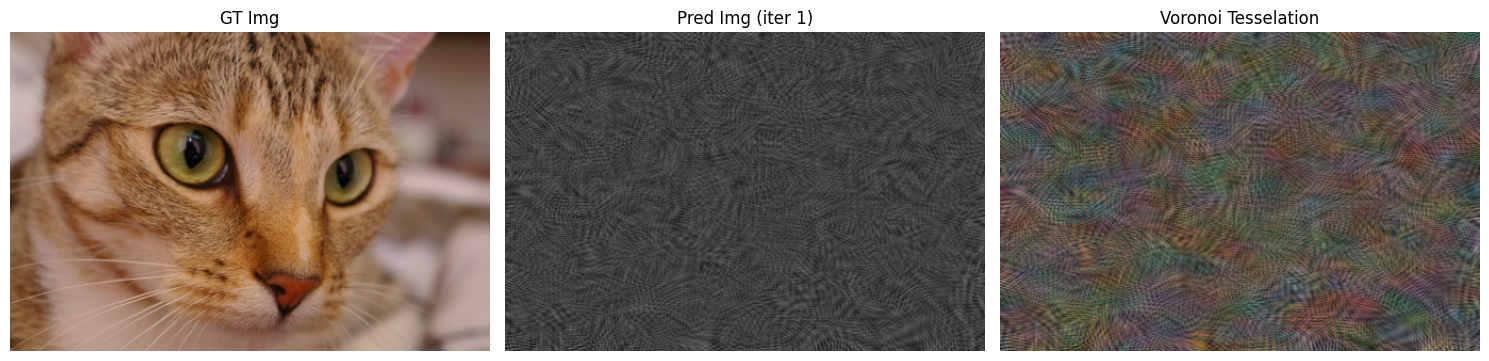

Training Voronoi Model:  25%|██▍       | 4996/20000 [02:19<07:14, 34.52it/s, psnr_b=30.21]

'VORONOI_reconstruct_map' executed in 0.3550 seconds


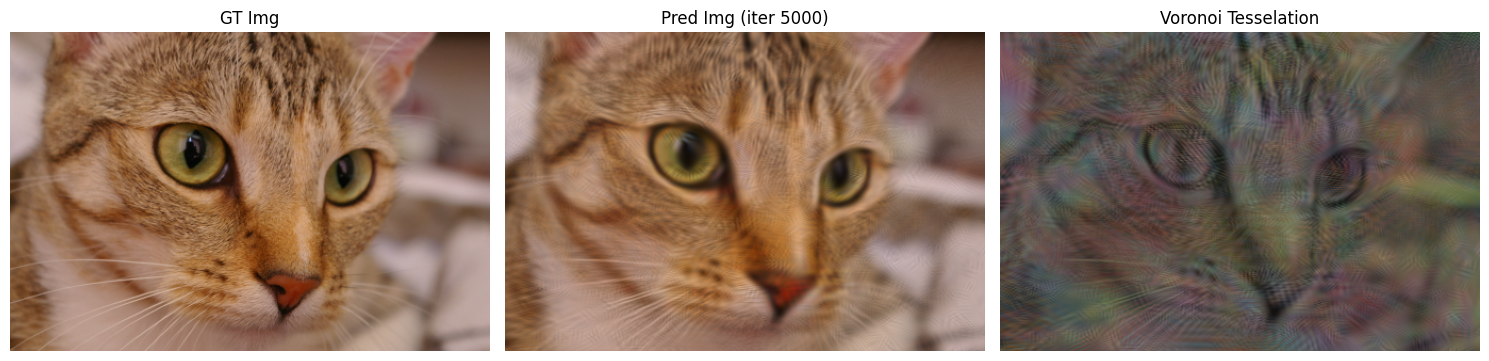

Training Voronoi Model:  50%|████▉     | 9999/20000 [04:38<04:34, 36.43it/s, psnr_b=31.15]

'VORONOI_reconstruct_map' executed in 0.3560 seconds


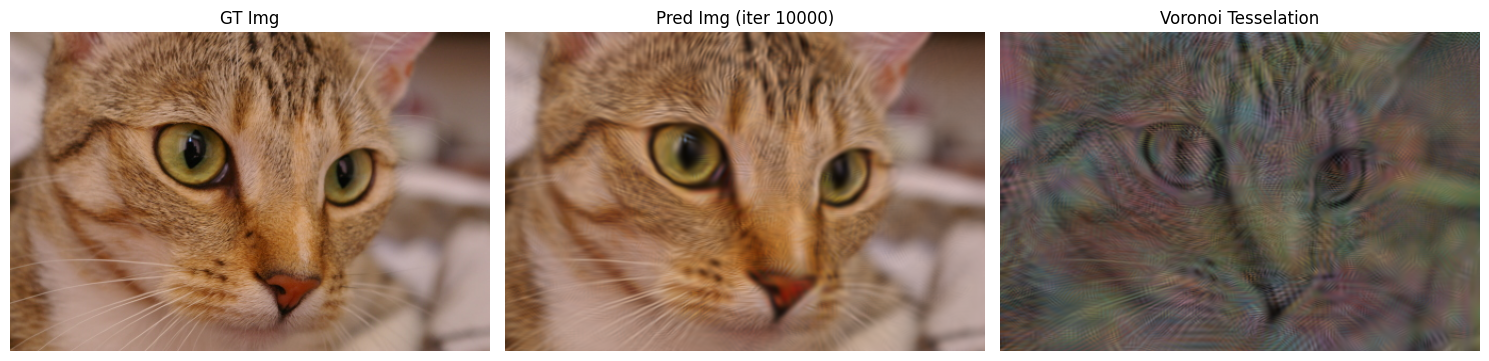

Training Voronoi Model:  75%|███████▍  | 14999/20000 [06:55<02:15, 36.79it/s, psnr_b=31.89]

'VORONOI_reconstruct_map' executed in 0.3573 seconds


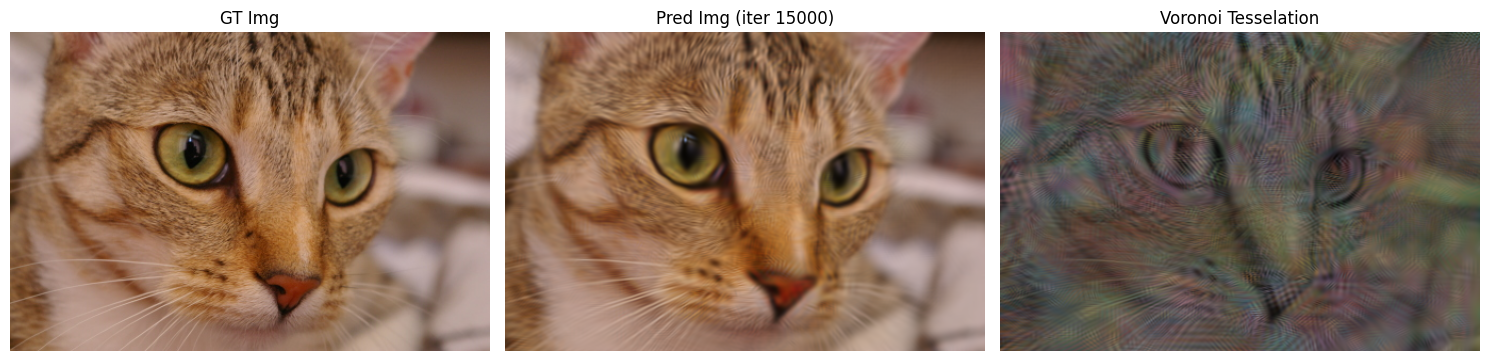

Training Voronoi Model: 100%|█████████▉| 19999/20000 [09:12<00:00, 36.97it/s, psnr_b=31.85]

'VORONOI_reconstruct_map' executed in 0.3574 seconds


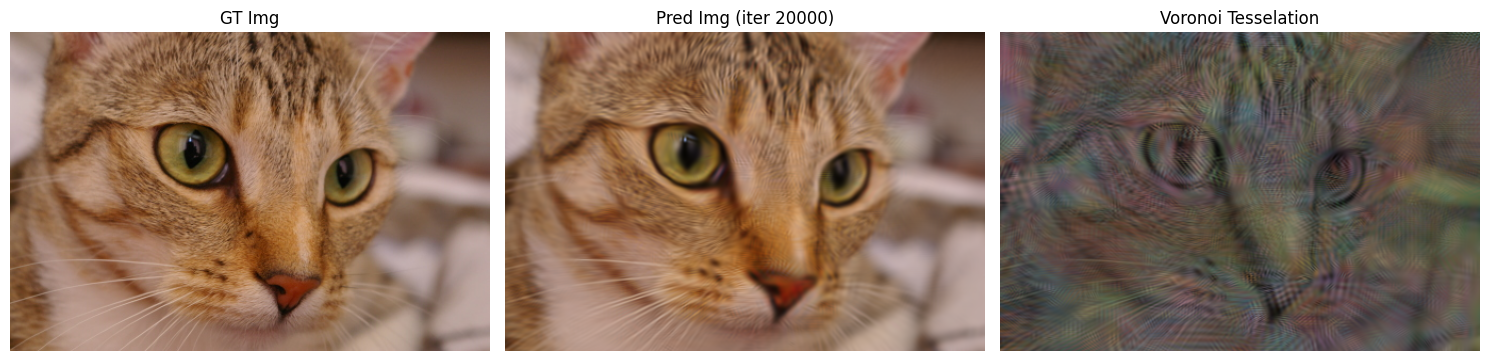

Training Voronoi Model: 100%|██████████| 20000/20000 [09:13<00:00, 36.11it/s, psnr_b=31.85]


In [ ]:
#gaboronoi is my favorite, but aniso voronoi and voronoi are what got me interested in this
model = train_env_model(
    "gaboronoi", #MODEL TYPES:  'voronoi', 'aniso_voronoi', 'gaboronoi', or 'simplex'
    img,
    model_kwargs={"num_sites": 3000, #only for voronoi
                  "init_beta": 1000, #only for voronoi
                  "num_noise_layers" : 50, #only for simplex
                  "aniso_texture_res" : 50, #only for simplex
                  },
    num_iters=15000,
    batch_size=4096,
    device=None,
    vis_interval=1000,
)